In [1]:
import numpy as np
import numpy.linalg as alg
import matplotlib.pyplot as plt
from qiskit.opflow import X,Z,I
from qiskit.providers.aer import QasmSimulator  
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA
from qiskit.circuit.library import EfficientSU2, TwoLocal
from qiskit.circuit import QuantumCircuit

In [2]:
def NKron(N,op1,op2,pos): 
    '''
    Tensor product operator 
    returns tensor product of op1,op2 on sites pos,pos+1 and identity on remaining sites

    N:number of sites
    op1,op2: Pauli operators on neighboring sites
    pos: site to insert op1
    
    '''
    ide=np.eye(2)
    temp=np.array([ide]*(N),dtype=np.complex128)
    temp[pos,:,:]=op1 
    if pos!=(N-1):
        temp[pos+1,:,:]=op2
    mat=1
    for j in range(N):
        mat=np.kron(mat,temp[j])
    return mat

def QNKron(N,op1,op2,pos): 
    '''
    Tensor product operator (Qiskit Pauli operators)
    returns tensor product of op1,op2 on sites pos,pos+1 and identity on remaining sites

    N:number of sites
    op1,op2: Pauli operators on neighboring sites
    pos: site to insert op1
    '''
    temp=np.array([I]*(N))
    temp[pos]=op1 
    if pos!=(N-1):
        temp[pos+1]=op2
    mat=1
    for j in range(N):
        mat=mat^temp[j]
    return mat

def HIsing(N,lam):
    '''
    Quantum Ising Hamiltonian (1D) with transverse field
    
    N:number of sites 
    lam: transverse field)
    '''
    sx=np.array([[0,1],[1,0]])
    sz=np.array([[1,0],[0,-1]])
    ide=np.eye(2)
    H=np.zeros((2**N,2**N))
    for i in range(N-1):
        H=H-NKron(N,sz,sz,i)-lam*NKron(N,sx,ide,i)-0.00001*NKron(N,sz,ide,i)
    H=H-lam*NKron(N,sx,ide,N-1)-0.00001*NKron(N,sz,ide,N-1)
    return H

def QHIsing(N,lam):
    '''
    Quantum Ising Hamiltonian (1D) with transverse field (Qiskit Pauli operators)
    
    N:number of sites 
    lam: transverse field)
    '''

    H=-QNKron(N,Z,Z,0)-lam*QNKron(N,X,I,0)
    for i in range(1,N-1):
        H=H-QNKron(N,Z,Z,i)-lam*QNKron(N,X,I,i)-0.00001*QNKron(N,Z,I,i)
    H=H-lam*QNKron(N,X,I,N-1)-0.00001*QNKron(N,Z,I,N-1)
    return H

def Mag(N):
    sz=np.array([[1,0],[0,-1]])
    M=np.zeros((2**N,2**N))
    for i in range(N):
        M=M+NKron(N,sz,np.eye(2),i)
    return M/N

# Run simulation for N=6 and save the parameters of the VQE

In [3]:
N=6 #number of sites

lams=np.logspace(-2,2,10)

backend= StatevectorSimulator()
optimizer = SLSQP(maxiter=1000)
ansatz = EfficientSU2(N, reps=3)
display(ansatz.draw(fold=100))

#backend= AerSimulator() 
#optimizer = SPSA(maxiter=1000)
#ansatz = EfficientSU2(N, reps=1)
#display(ansatz.draw(fold=100))

vqe = VQE(ansatz, optimizer, quantum_instance=backend) 

en=np.zeros(len(lams)); Qen=np.zeros(len(lams)) #arrays of energies
mags=np.zeros(len(lams)); Qmags=np.zeros(len(lams)) #arrays of magnetizations

parameters_ansatz = dict()

for j,lam in enumerate(lams):
    
    print('lambda: %.2f' %lam)
    
    ham=HIsing(N,lam) #Numpy Hamiltonian
    Qham=QHIsing(N,lam) #Qiskit Hamiltonian
    
    vals,vecs=alg.eigh(ham) #ED with Numpy
    en[j]=vals[0]
    vecs = vecs.T
    result = vqe.compute_minimum_eigenvalue(Qham) #ED with Qiskit VQE
    Qen[j]=result.eigenvalue
    
    mags[j]=vecs[0].T.conj()@Mag(N)@vecs[0] #Magnetization with Numpy results
    Qmags[j]=np.array(result.eigenstate).T.conj()@Mag(N)@np.array(result.eigenstate) #Magnetization with Qiskit results
    #Qmags[j]=np.array(list(result.eigenstate.values())).T.conj()@Mag(N)@np.array(list(result.eigenstate.values())) #Magnetization with Qiskit results
    
    parameters_ansatz[str(lam)] = result.optimal_parameters
    
np.save('params_VQE_ising_N%.0f.npy' %N, parameters_ansatz)

┌──────────┐ ┌──────────┐                                   ┌───────────┐┌───────────┐     »
q_0: ┤ RY(θ[0]) ├─┤ RZ(θ[6]) ├──■────■────■─────────■─────────■──┤ RY(θ[12]) ├┤ RZ(θ[18]) ├─────»
     ├──────────┤ ├──────────┤┌─┴─┐  │    │         │         │  └───────────┘└───────────┘     »
q_1: ┤ RY(θ[1]) ├─┤ RZ(θ[7]) ├┤ X ├──┼────┼────■────┼────■────┼────────■─────────────────────■──»
     ├──────────┤ ├──────────┤└───┘┌─┴─┐  │  ┌─┴─┐  │    │    │        │                     │  »
q_2: ┤ RY(θ[2]) ├─┤ RZ(θ[8]) ├─────┤ X ├──┼──┤ X ├──┼────┼────┼────────┼────────────■────────┼──»
     ├──────────┤ ├──────────┤     └───┘┌─┴─┐└───┘  │  ┌─┴─┐  │        │          ┌─┴─┐      │  »
q_3: ┤ RY(θ[3]) ├─┤ RZ(θ[9]) ├──────────┤ X ├───────┼──┤ X ├──┼────────┼──────────┤ X ├──────┼──»
     ├──────────┤┌┴──────────┤          └───┘     ┌─┴─┐└───┘  │      ┌─┴─┐        └───┘      │  »
q_4: ┤ RY(θ[4]) ├┤ RZ(θ[10]) ├────────────────────┤ X ├───────┼──────┤ X ├───────────────────┼──»
     ├──────────┤├───────────┤                    └───┘     ┌─┴─┐    └───┘                 ┌─┴─┐»
q_5: ┤ RY(θ[5]) ├┤ RZ(θ[11]) ├──────────────────────────────┤ X ├──────────────────────────┤ X ├»
     └──────────┘└───────────┘                              └───┘                          └───┘»
«                                                                                                »
«q_0: ────────────────────────────────■─────────────────────────■─────────────────────────■──────»
«     ┌───────────┐┌───────────┐    ┌─┴─┐                       │                         │      »
«q_1: ┤ RY(θ[13]) ├┤ RZ(θ[19]) ├────┤ X ├───────────────────────┼────────────■────────────┼──────»
«     └───────────┘└───────────┘┌───┴───┴───┐┌───────────┐    ┌─┴─┐        ┌─┴─┐          │      »
«q_2: ──────■────────────■──────┤ RY(θ[14]) ├┤ RZ(θ[20]) ├────┤ X ├────────┤ X ├──────────┼──────»
«           │            │      └───────────┘└───────────┘┌───┴───┴───┐┌───┴───┴───┐    ┌─┴─┐    »
«q_3: ──────┼────────────┼────────────■────────────■──────┤ RY(θ[15]) ├┤ RZ(θ[21]) ├────┤ X ├────»
«         ┌─┴─┐          │          ┌─┴─┐          │      └───────────┘├───────────┤┌───┴───┴───┐»
«q_4: ────┤ X ├──────────┼──────────┤ X ├──────────┼────────────■──────┤ RY(θ[16]) ├┤ RZ(θ[22]) ├»
«         └───┘        ┌─┴─┐        └───┘        ┌─┴─┐        ┌─┴─┐    ├───────────┤├───────────┤»
«q_5: ─────────────────┤ X ├─────────────────────┤ X ├────────┤ X ├────┤ RY(θ[17]) ├┤ RZ(θ[23]) ├»
«                      └───┘                     └───┘        └───┘    └───────────┘└───────────┘»
«                    ┌───────────┐┌───────────┐                                            »
«q_0: ──■─────────■──┤ RY(θ[24]) ├┤ RZ(θ[30]) ├─────────────────────────────────────■──────»
«       │         │  └───────────┘└───────────┘     ┌───────────┐┌───────────┐    ┌─┴─┐    »
«q_1: ──┼────■────┼────────■─────────────────────■──┤ RY(θ[25]) ├┤ RZ(θ[31]) ├────┤ X ├────»
«       │    │    │        │                     │  └───────────┘└───────────┘┌───┴───┴───┐»
«q_2: ──┼────┼────┼────────┼────────────■────────┼────────■────────────■──────┤ RY(θ[26]) ├»
«       │  ┌─┴─┐  │        │          ┌─┴─┐      │        │            │      └───────────┘»
«q_3: ──┼──┤ X ├──┼────────┼──────────┤ X ├──────┼────────┼────────────┼────────────■──────»
«     ┌─┴─┐└───┘  │      ┌─┴─┐        └───┘      │      ┌─┴─┐          │          ┌─┴─┐    »
«q_4: ┤ X ├───────┼──────┤ X ├───────────────────┼──────┤ X ├──────────┼──────────┤ X ├────»
«     └───┘     ┌─┴─┐    └───┘                 ┌─┴─┐    └───┘        ┌─┴─┐        └───┘    »
«q_5: ──────────┤ X ├──────────────────────────┤ X ├─────────────────┤ X ├─────────────────»
«               └───┘                          └───┘                 └───┘                 »
«                                                                        ┌───────────┐┌───────────┐»
«q_0: ───────────────────■─────────────────────────■────────■─────────■──┤ RY(θ[36]) ├┤ RZ(θ[42]) ├»
«                        │       

lambda: 0.01


KeyboardInterrupt: 

## Plot resulting energies and magnetization

Text(0, 0.5, 'Magnetization')

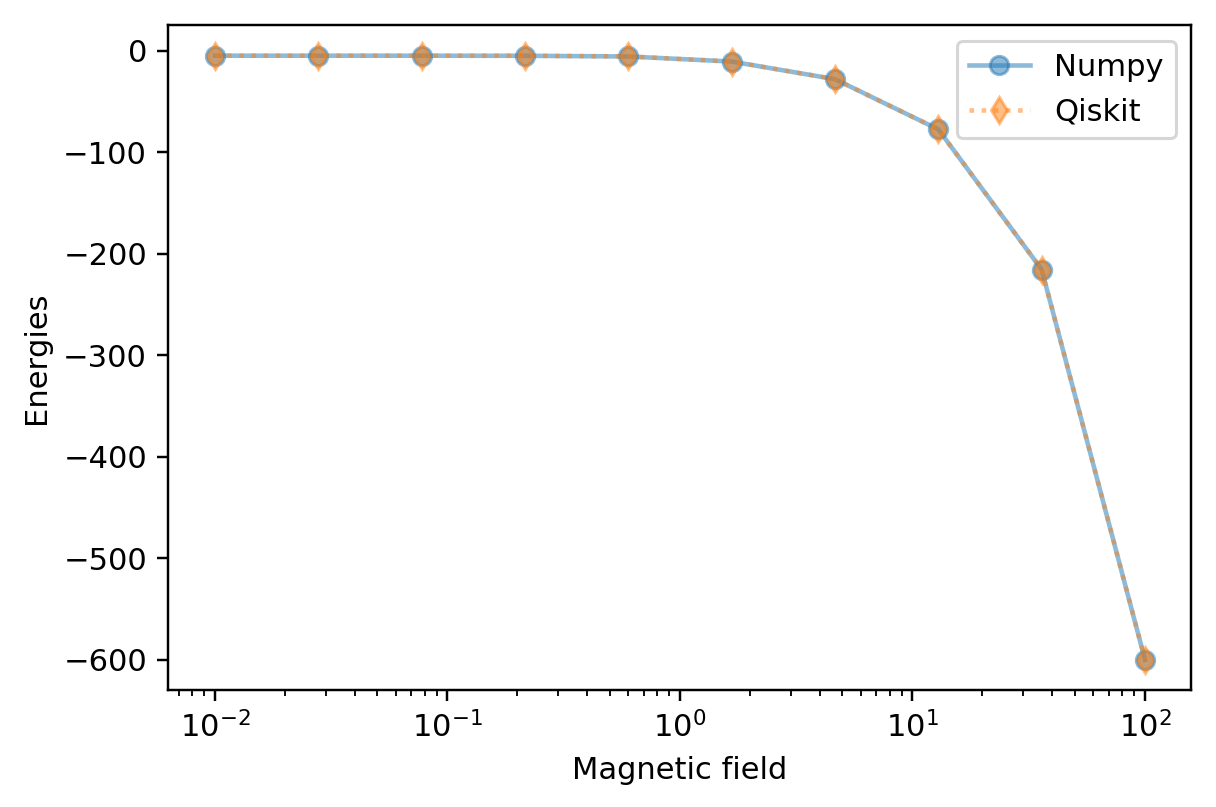

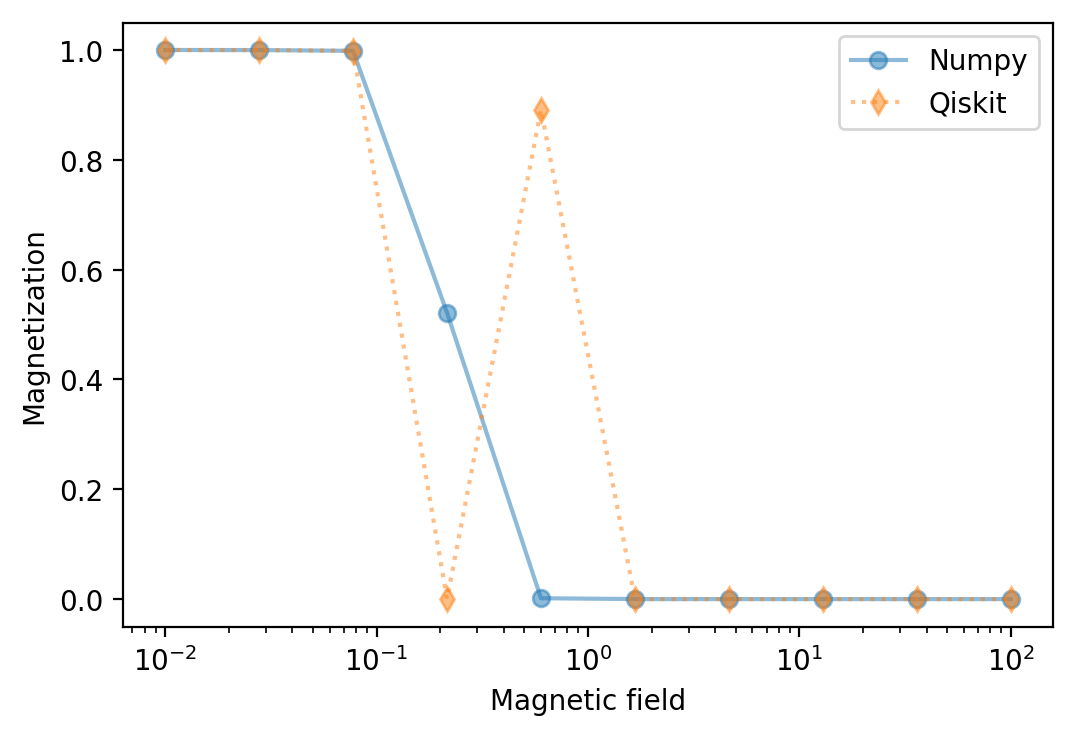

In [6]:
plt.figure(dpi=220)
plt.plot(lams,en,'o-', alpha=0.5)
plt.plot(lams,Qen, 'd:', alpha=0.5)
plt.legend(["Numpy","Qiskit"])
plt.xscale("log")
plt.xlabel("Magnetic field")
plt.ylabel("Energies")

plt.figure(dpi=200)
plt.plot(lams,abs(mags),'o-', alpha=0.5)
plt.plot(lams,abs(Qmags), 'd:', alpha=0.5)
plt.legend(["Numpy","Qiskit"])
plt.xscale("log")
plt.xlabel("Magnetic field")
plt.ylabel("Magnetization")

# Use the saved parameters to define unitary transformation

In [13]:
N = 6
lams=np.logspace(-2,2,10)
parameters_ansatz = np.load('params_VQE_ising_N%.0f.npy' %N, allow_pickle=True)

for lam in lams:
    optimal_params = parameters_ansatz[str(lam)]
    ansatz = EfficientSU2(N, reps=3)
    ansatz = ansatz.assign_parameters(optimal_params)
    
qc = QuantumCircuit(4)  
qc.compose(ansatz, inplace=True)
qc.draw()
backend= StatevectorSimulator()
qc_result = execute(qc, backend)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices